# Final Project ML with Probabilistic Programming 
## Fall 2018, Columbia University
### Jan-Felix Schneider (jfs2160), Brian Allen (ba2542) 

# Introduction 

The spread of a contagion in a network has many applications: diseases spread through cities, news spread through media pages, behavior spread through social networks. However, the data observed in nature usually only provides the infection times and not which node infected which neighbor. 

In this project, we would like to infer an underlying "influence network" from a set of cascades, a set of node and their infection times. We're building our efforts on the work of Rodriguez et al [1], who built a probability model on the independent cascade model developed by Kempe et al [2]. Our main effort was to adapt this model to a probabilistic programming setting.

As an extension to the base, we hypothesize that cascades with added context may alter how infections spread throughout a network. For example, a viral story may spread differently if the context is politics rather than sports. 


### Given Empty Graph

In [47]:
from hdiffnet.utils import * 
from hdiffnet.cascade_generator import GenerativeModel
from hdiffnet.preprocessing import Preprocessing
from hdiffnet.hdiffnet import ProbabilityModel
import matplotlib.pyplot as plt

import pandas as pd
from tensorflow_probability import edward2 as ed

In [2]:


nx_graph, nx_layout, nx_weights, nx_labels = buildGraph(alpha)

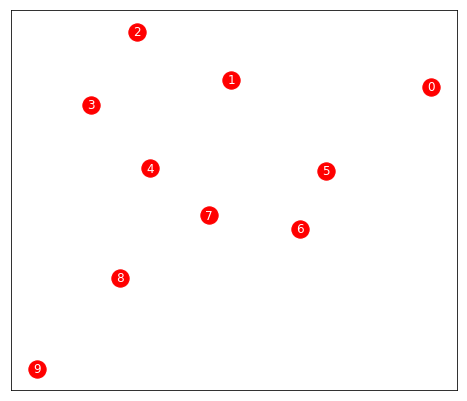

In [3]:
drawEmptyGraph(nx_graph, nx_layout, nx_labels)

### Observe Set of Cascades

In [ ]:
drawNetworkProp(nx_graph, nx_layout, nx_labels, sampleCascade(alpha, 10), 10)

### Infer Network Structure

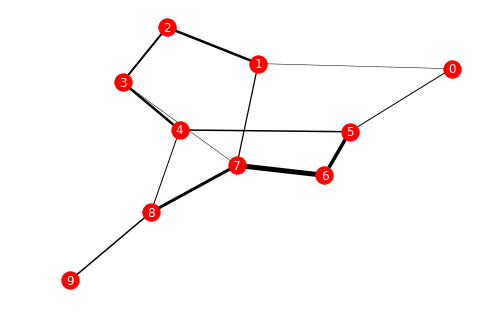

In [5]:
drawWeightedGraph(nx_graph, nx_layout, nx_weights, nx_labels)

# Models

## Base Model

### Transmission Parameters

Transmission parameters, $\alpha_{ij} > 0$ are defined for each pair of nodes as the infection rate from node $i$ to node $j$. When modeled as parameters of an Exponential distribution, the resulting set of observations $\tau$ are interarrival times of infections from node $i$ to $j$.

As an extension, we incorporate an Exponential prior on each $\alpha_{ij}$ to incorporate prior knowledge about the underlying network. 

### Cascade Likelihood

All work on inferring diffusion networks (Rodriguez et al [1]) defines a likelihood function over the cascades to estimate the maxmium likelihood of the transmission parameters between nodes. The work defines an exponential diffusion model using the following log-likelihood:

$p(C=c) = \Pi_{t_i \leq T} \Pi_{t_m > T} S(T|t_i, \alpha_{i,m}) \cdot \Pi_{t_j > t_i} S(t_i|t_j, \alpha_{j,i}) \sum_{t_j < t_i} H(t_i| t_k, \alpha_{k,i})$

This probability can be calculated with a series of tensor operations. However, this likehlihood does not lend itself to a pure generative model and is therefore difficult to incorporate into Edward's framework.

Further derivations can be found in the [paper](http://snap.stanford.edu/class/cs224w-readings/rodriguez11diffusion.pdf) 

### Cascade Seed

Each cascade must have a starting point. Since this is an input into the cascade generative process, we draw a random cascade seed $S$ from a categorical distribution assuming all seeds are equally likely.

### Generative Model

- For each pair of nodes $(i,j)$:
    - Draw $\alpha_{ij} \sim$ Exp$(1)$
- For each cascade:
     - For each pair of nodes $(i,j)$:
        - Draw infection times $\tau_{ij} \sim$ Exp$(\alpha_{ij})$
     - Draw cascade seed $S \sim $Cat$(\delta)$
     - Observe the shortest path $C \sim $Shortest Path$(\tau,S)$

### Graphical Model

<img src="illustrations/model_with_prior.png" alt="drawing" style="width:500px;"/>

### Parameter Estimation

Coding shortest path as a generative model was outside the scope of our work, since it is not clear this is a differentiable procedure. In order to work around generating shortest path cascades, we then used cascade likelihood as the likelihood of the entire cascade plate. Coding a new random variable class for the cascade proved to be difficult in the amount of time for this project, which limited the parameter estimation procedures to MAP estimation. However, once the random variable class is built, inference can be expanded to the suite of tools used for probabilistic machine learning (e.g. CAVI, BBVI, MCMC, etc.)

## Cascade Topic Model

### Cascade Topic Assignment

Each cascade draws a topic assignment $Z$ from $K$ topics, with a predefined categorical probabilities $\theta$. For this model, $Z$ is a one-hot encoded vector, however it is trivial to extend the model to incorporate cascades with a mixture of topics.

### Transmission Parameters

In this model,  the $\alpha$ parameter is broken into $\alpha_0$ and $\alpha_1$. For a given cascade, define $\alpha = $Relu$(\alpha_0+\alpha_1 \cdot Z)$, where $\alpha_0$ acts as a $NxN$ intercept and $\alpha_1$ is a $NxNxK$ tensor where $k^{th}$ $NxN$ slice is activated when $Z=k$. This $\alpha_1$ parameter captures the polarity the node has for the given topic. A high similarity between the nodes polarity and the topic assignment, the more likely transmission.

### Generative Model

- For each pair of nodes $(i,j)$:
    - Draw $\alpha_0 \sim$ Exp$(1)$
    - For each topic K:
        - Draw $\alpha_1 \sim$ Exp$(1)$
- For each cascade:
     - Draw topic assignment $Z \sim $ Cat$(\theta)$:
     - For each pair of nodes $(i,j)$:
        - Draw infection times $\tau_{ij} \sim$ Exp$($Relu$(\alpha_0+\alpha_1 \cdot Z)$$)$
     - Draw cascade seed $S \sim $Cat$(\delta)$
     - Observe the shortest path $C \sim $Shortest Path$(\tau,S)$

### Graphical Model

<img src="illustrations/model_with_polarity.png" alt="drawing" style="width:500px;"/>

# Data - Memetracker


The raw memetracker dataset includes a phrase, a phrase id, a related phrase cluster, the URL of a webpage and a timestamp. For our analysis, we included the top 200 webpages (to reduce the size of the dataset) and transformed the dataset, such that we assumed a phrase to be a cascade. 

In order to extract topic information from the cascades, we performed string searches for common political words (e.g. "politics", "republican", democractics", etc.) and common sports words ("NFL", "football", "player", etc.) String matches categorized the topic as either politics-related or sports-related - more complex procedured can be imagined. 

In [ ]:
#process the raw data and add topics to the cascades
p = Preprocessing("data/clust-qt08080902w3mfq5.txt")
p.preprocess_data(200)
p.add_polarity()

In [11]:
#load the preloaded data
p.data = pd.read_csv('data/clean_data.csv')
r, topics = transform_full_to_sparse(p.data, topics=True)

In [ ]:
p.data.to_csv('data/clean_data.csv')

# Base Model Inference

The inference method used was MAP estimation, due to our difficulties with the random variable class within tensorflow. In particular, we employed the L-BFGS optimizer within tensorflow to model the transmission parameters.

In [29]:
# Feed the data into a tensorflow log-prior model.
max_T = p.data.t.max()
numNodes = 200
model = ProbabilityModel(r[:2100], numNodes, T = max_T)

In [30]:
%time a1 = model.map_estimate_BFGS(max_iter=1000)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: -0.000000
  Number of iterations: 26
  Number of functions evaluations: 30
CPU times: user 11min 41s, sys: 2min 18s, total: 14min
Wall time: 4min 43s


In [31]:
#batch updates for the whole dataset
a_prior = model.batch_update(batch_size=400)


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 32.737339
  Number of iterations: 66
  Number of functions evaluations: 118
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 31.990635
  Number of iterations: 45
  Number of functions evaluations: 88
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 16.188795
  Number of iterations: 47
  Number of functions evaluations: 159
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 34.193008
  Number of iterations: 55
  Number of functions evaluations: 81
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 35.680580
  Number

# Cascade Topic Model Inference


For model 2, we generated cascade data for two topics from two sets of alpha parameters. The first set of alpha parameters for the ground truth of topic 1 network parameters and the second set for the ground truth of topic 2 network parameters.

In [72]:
# Feed the data into a tensorflow log-prior model.
max_T = p.data.t.max()
numNodes = 200
model_topic = ProbabilityModel(r[:100], numNodes, T=max_T, topics=topics[:100])

In [73]:
a_topic = model_topic.map_estimate_BFGS_topics(max_iter=1000)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 1284181.750000
  Number of iterations: 19
  Number of functions evaluations: 60


# Base Model Criticism


To test whether our model can describe how contagion is spreading, we are using a set of cascades, we did not train our model on and obtain the posterior predictive, by generating a cascade.


In [41]:
# get test set and observable variables
test_set = r[-25:]
seeds = get_seed_set(test_set)
times = get_max_times(test_set)
test_set = convert_to_matrix(test_set, numNodes, times)
test_topics = topics[-25:,:]

In [42]:
# generate cascades with the learned parameters
gm = GenerativeModel(model.a, numNodes)
test_cascades = gm.build_cascade_series(seeds, times)


100%|██████████| 25/25 [09:20<00:00, 26.34s/it]


In [49]:
# generate a benchmark cascade according to the seed set
sess=tf.Session()
alpha = ed.Gamma(tf.ones((numNodes,numNodes)),tf.ones((numNodes,numNodes)))
a_bench = sess.run(alpha)

gm = GenerativeModel(a_bench, numNodes)
benchmark_cascades = gm.build_cascade_series(seeds, times)


100%|██████████| 25/25 [10:51<00:00, 24.48s/it]


We are using several metrics to criticise our model: 

* MSE and MAE: how good can we predict infection times 
* Kendall rank corellation coefficient: how good can we predict infection order 
* Precision: how good can we predict the cascade set

In [54]:
evaluate(test_set, test_cascades, benchmark_cascades, times)

metric	 set	 	 value
_______|_____________|______________________
MSE	 benchmark	19276.0
MSE	 model  	1644.0
MAE	 benchmark	126.0
MAE	 model  	10.0
KRCC 	 benchmark	0.011
KRCC 	 model  	0.683
Prec	 benchmark	0.072
Prec	 model  	0.136


#  Criticism

In [ ]:
# generate cascades according to the seed set
gm = GenerativeModel(a_topic, numNodes)
test_cascades_t = gm.build_topic_cascades(seeds, times, test_topics)

In [ ]:
evaluate(test_set, test_cascades_t, benchmark_cascades, times)

# Issues with Edward

## Non-Differentiability of Shortest Path

As mentioned in the model section, our struggle with Edward is concentrated in defining the shortest path operation on the $\tau$ transmission times. Since this is operation is non-differentiable, this is a non-trivial problem for performing inference. There is some work today about estimating shortest path using a recurrent neural network, however this is left for future work.

## Issues with Random Variable Class

As mentioned in the base model - parameter estimation section, we transitioned from working with generating a shortest path to evaluating the log probability of the cascade as part of the probabilistic model. Within Tensorflow and Edward, we can define a new random variable class that requires defining the log probability and sampling distribution. This proved to be time-consuming and difficult to debug. In order to get results, we stopped working with Edward's random variable class and built the algorithm by manually defining the log probability in tensorflow.


# Future Work

## Modeling

- Adding a Dirichlet prior to the topic draws, which allow for different probabilities of topic assignments
- Adding a Dirichlet prior to the seed draws, which allow for different probabilities of seed assignments 
- Allowing for mixture topic assignments

## Inference

- Build out the Cascade random variable in Edward
- Explore ways to incorporate differentiable shortest path (e.g. RNN)
- Make the inference scalable for large datasets

## Criticism

- Toggle hyperparameters to ensure inferred network diameter aligns with reality

# References

[1] Rodriguez, M. G., Balduzzi, D., & Schölkopf, B. (2011). Uncovering the temporal dynamics of diffusion networks. arXiv preprint arXiv:1105.0697.

[2] Kempe, D., Kleinberg, J., & Tardos, É. (2003, August). Maximizing the spread of influence through a social network. In Proceedings of the ninth ACM SIGKDD international conference on Knowledge discovery and data mining (pp. 137-146). ACM.

[3] Amini, Hamed, and Marc Lelarge. "The diameter of weighted random graphs." The Annals of Applied Probability 25.3 (2015): 1686-1727.
